In [1]:
# import packages
# !pip install pandas
# !pip install xlrd==1.2.0
# !pip install openpyxl
# !pip install matplotlib
# !pip install keras
# !pip install tensorflow
# !pip install tqdm
#!pip install numba==0.53

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

import torch
#import librosa
#import librosa.display

In [3]:
import os

In [4]:
import logging
import sys

logger = logging.getLogger()
logger.setLevel(logging.INFO)
formatter = logging.Formatter('%(asctime)s | %(levelname)s | %(message)s', '%H:%M:%S')

stdout_handler = logging.StreamHandler(sys.stdout)
stdout_handler.setLevel(logging.DEBUG)
stdout_handler.setFormatter(formatter)

file_handler = logging.FileHandler('logs.log')
file_handler.setLevel(logging.DEBUG)
file_handler.setFormatter(formatter)

logger.handlers = []
logger.addHandler(file_handler)
logger.addHandler(stdout_handler)

logger.info("logger system works!")

11:43:55 | INFO | logger system works!


## Data Preparation

In [5]:
def load_excel(filename):
    data = pd.read_excel(filename, index_col=None, usecols=[1, 2, 3])
    data = data.dropna(how='any').iloc[::-1]
    data = data.loc[~(data==0).all(axis=1)]
    xlist = reject_outliers(data['1号球磨轴承振动_X'].tolist())
    ylist = reject_outliers(data['1号球磨轴承振动_Y'].tolist())
    zlist = reject_outliers(data['1号球磨轴承振动_Z'].tolist())
    return xlist, ylist, zlist

In [6]:
def reject_outliers(data, m=2):
    mean = np.mean(data)
    std = np.std(data)
    m = 4
    logger.info("max: {}".format(mean+m*std))
    log_str = ""
    count = 0
    for i in range(len(data)) :
        # if np.abs(data[i]) > mean + m*std or data[i] < 0 :
        if np.abs(data[i]) > 10 or data[i] < 0 :
            log_str += "{}, ".format(data[i])

            count += 1
            data[i] = data[i-1]

    # # double times
    # for i in range(len(data)):
    #     if np.abs(data[i]) > mean + m*std or data[i] < 0 :
    #         log_str += "{}, ".format(data[i])
    #         count += 1
    #         data[i] = data[i-1]

    if count > 0:
        logger.info("Reject {} outlier data: ".format(count) + log_str)
    return data

In [7]:
# Normalization data to [0, 1]
def normalization_from_0_to_1(data):
    min_value = tf.reduce_min(data)
    max_value = tf.reduce_max(data)

    data = (data - min_value) / (max_value - min_value)
    data = tf.cast(data, tf.float32)
    return data

In [8]:
def split_list(input_array, sublist_length):
    rest = len(input_array) % sublist_length
    print("rest:",rest)
    new_arr = input_array[rest:]
    #return np.array_split(input_array, np.arange(sublist_length,len(input_array),sublist_length))
    return np.array_split(new_arr, len(new_arr)/sublist_length)

In [9]:
al = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
print(split_list(al, 2))

rest: 1
[array([2, 3]), array([4, 5]), array([6, 7]), array([8, 9]), array([10, 11])]


In [10]:
import pickle
def save_pickle(filename, save_data):
    logger.info("save pickle -> {}".format(filename))
    with open(filename, 'wb') as sf:
        pickle.dump(save_data, sf)

def load_pickle(filename):
    logger.info(f"load pickle <- {filename}")
    with open(filename, 'rb') as lf:
        load_data = pickle.load(lf)
    return load_data

In [12]:
import glob, os

x_pickle = "data/pickle/x.pickle"
y_pickle = "data/pickle/y.pickle"
z_pickle = "data/pickle/z.pickle"

# pickle
if os.path.exists(x_pickle) and os.path.exists(y_pickle) and os.path.exists(z_pickle):
    xlist_sum = load_pickle(x_pickle)
    ylist_sum = load_pickle(y_pickle)
    zlist_sum = load_pickle(z_pickle)
else:
    xlist_sum = ylist_sum = zlist_sum = []
    for file in tqdm(glob.glob("data/excels/*.xlsx")):
        logger.info("Load data from file {}".format(file))
        xlist, ylist, zlist = load_excel(file)
        xlist_sum.extend(xlist)
        ylist_sum.extend(ylist)
        zlist_sum.extend(zlist)
    xlist_sum = normalization_from_0_to_1(xlist_sum)
    ylist_sum = normalization_from_0_to_1(ylist_sum)
    zlist_sum = normalization_from_0_to_1(zlist_sum)

    save_pickle(x_pickle, xlist_sum)
    save_pickle(y_pickle, ylist_sum)
    save_pickle(z_pickle, zlist_sum)

11:47:59 | INFO | load pickle <- data/pickle/x.pickle
11:47:59 | INFO | load pickle <- data/pickle/y.pickle
11:47:59 | INFO | load pickle <- data/pickle/z.pickle


In [13]:
sublist_size = 1024
xs = split_list(xlist_sum, sublist_size)
print(len(xs),len(xs[1]))
xlists = np.asarray(split_list(xlist_sum, sublist_size), dtype='float32')
ylists = np.asarray(split_list(ylist_sum, sublist_size), dtype='float32')
zlists = np.asarray(split_list(zlist_sum, sublist_size), dtype='float32')

rest: 92
4510 1024
rest: 92
rest: 92
rest: 92


In [14]:
# combine x, y, z array to a 2D array
combine_data = np.stack((xlists, ylists, zlists), axis=-1)
reshaped_combine_data = np.reshape(combine_data, (4510,3*1024), 'C')
reshaped_combine_data.shape

(4510, 3072)

## Data Visualization

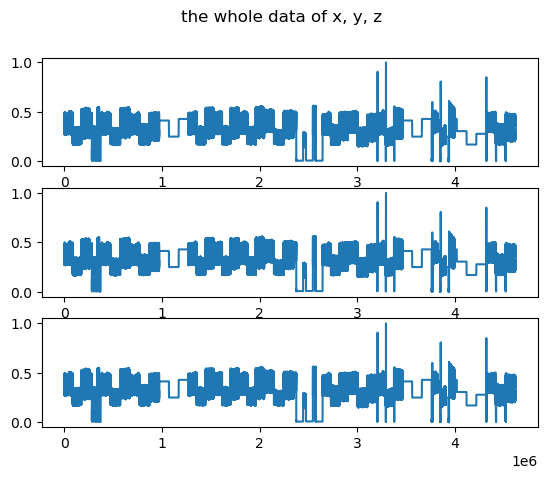

In [15]:
fig, axs = plt.subplots(3)
fig.suptitle('the whole data of x, y, z')
axs[0].plot(xlist_sum)
axs[1].plot(ylist_sum)
axs[2].plot(zlist_sum)

In [16]:
# count the num of zeros
# count = 0
# for i in ylist_sum:
#     if i == 0:
#         count += 1
# logger.info(f"count of zeros: {count}")

## Model Building

In [17]:
import tensorflow as tf
from tensorflow.keras import layers

In [18]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [19]:
from model import conv2d, entropy_loss
from torch import nn

model_conv2D = conv2d.AutoEncoderConv2d(3).to(device)
tr_recon_loss_func = nn.MSELoss().to(device)
tr_entropy_loss_func = entropy_loss.EntropyLossEncap().to(device)
tr_optimizer = torch.optim.Adam(model_conv2D.parameters(), lr=1e-4)
# I need to write a DataLoader method

from torch.utils.data import DataLoader
train_loader = DataLoader(reshaped_combine_data, batch_size=128, shuffle=False, num_workers=4, pin_memory=True)

epochs = 100
for epoch in tqdm(range(epochs)):
    loss = 0
    for batch_features in tqdm(train_loader):
        print(batch_features.shape)
        batch_features = batch_features.to(device)
        tr_optimizer.zero_grad()
        outputs = model_conv2D(batch_features)
        train_loss = tr_recon_loss_func(outputs, batch_features)
        train_loss.backward()
        tr_optimizer.step()
        loss += train_loss.item()

    loss /= len(train_loader)

    print("epoch: {epoch}, loss: {loss} ")

m = nn.Conv2d(16, 33, 3, stride=2)
# input_channels, output_channels, kernels_size, stride
input_for_this_test = torch.randn(20, 16, 50, 100)
output_for_this_test = m(input_for_this_test)

In [21]:
def keras_model(inputDim):
    inputLayer = Input(shape=(inputDim,))
    # add a flatten layer
    x = tf.keras.layers.Flatten()(inputLayer)
    x = Dense(128, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(  8, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    # add a flatten layer
    x = tf.keras.layers.Flatten()(x)
    x = Dense(inputDim, activation=None)(x) # or sigmoid
    return Model(inputs=inputLayer, outputs=x)

In [22]:
class Visualizer(object):
    def __init__(self):
        self.plt = plt
        self.fig = self.plt.figure(figsize=(30, 10))
        self.plt.subplots_adjust(wspace=0.3, hspace=0.3)

    def loss_plot(self, loss, val_loss):
        ax = self.fig.add_subplot(1, 1, 1)
        ax.cla()
        ax.plot(loss)
        ax.plot(val_loss)
        ax.set_title("Model loss")
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Loss")
        ax.legend(["Train", "Test"], loc="upper right")

    def save_figure(self, filename):
        self.plt.savefig(filename)

In [23]:
# remove the stored model files
try:
    os.remove('model/history.png')
    os.remove('model/model.hdf5')
    print('Model Files Removed!')
except OSError as error:
    print('No model files exist')

Model Files Removed!


(4510, 3072)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

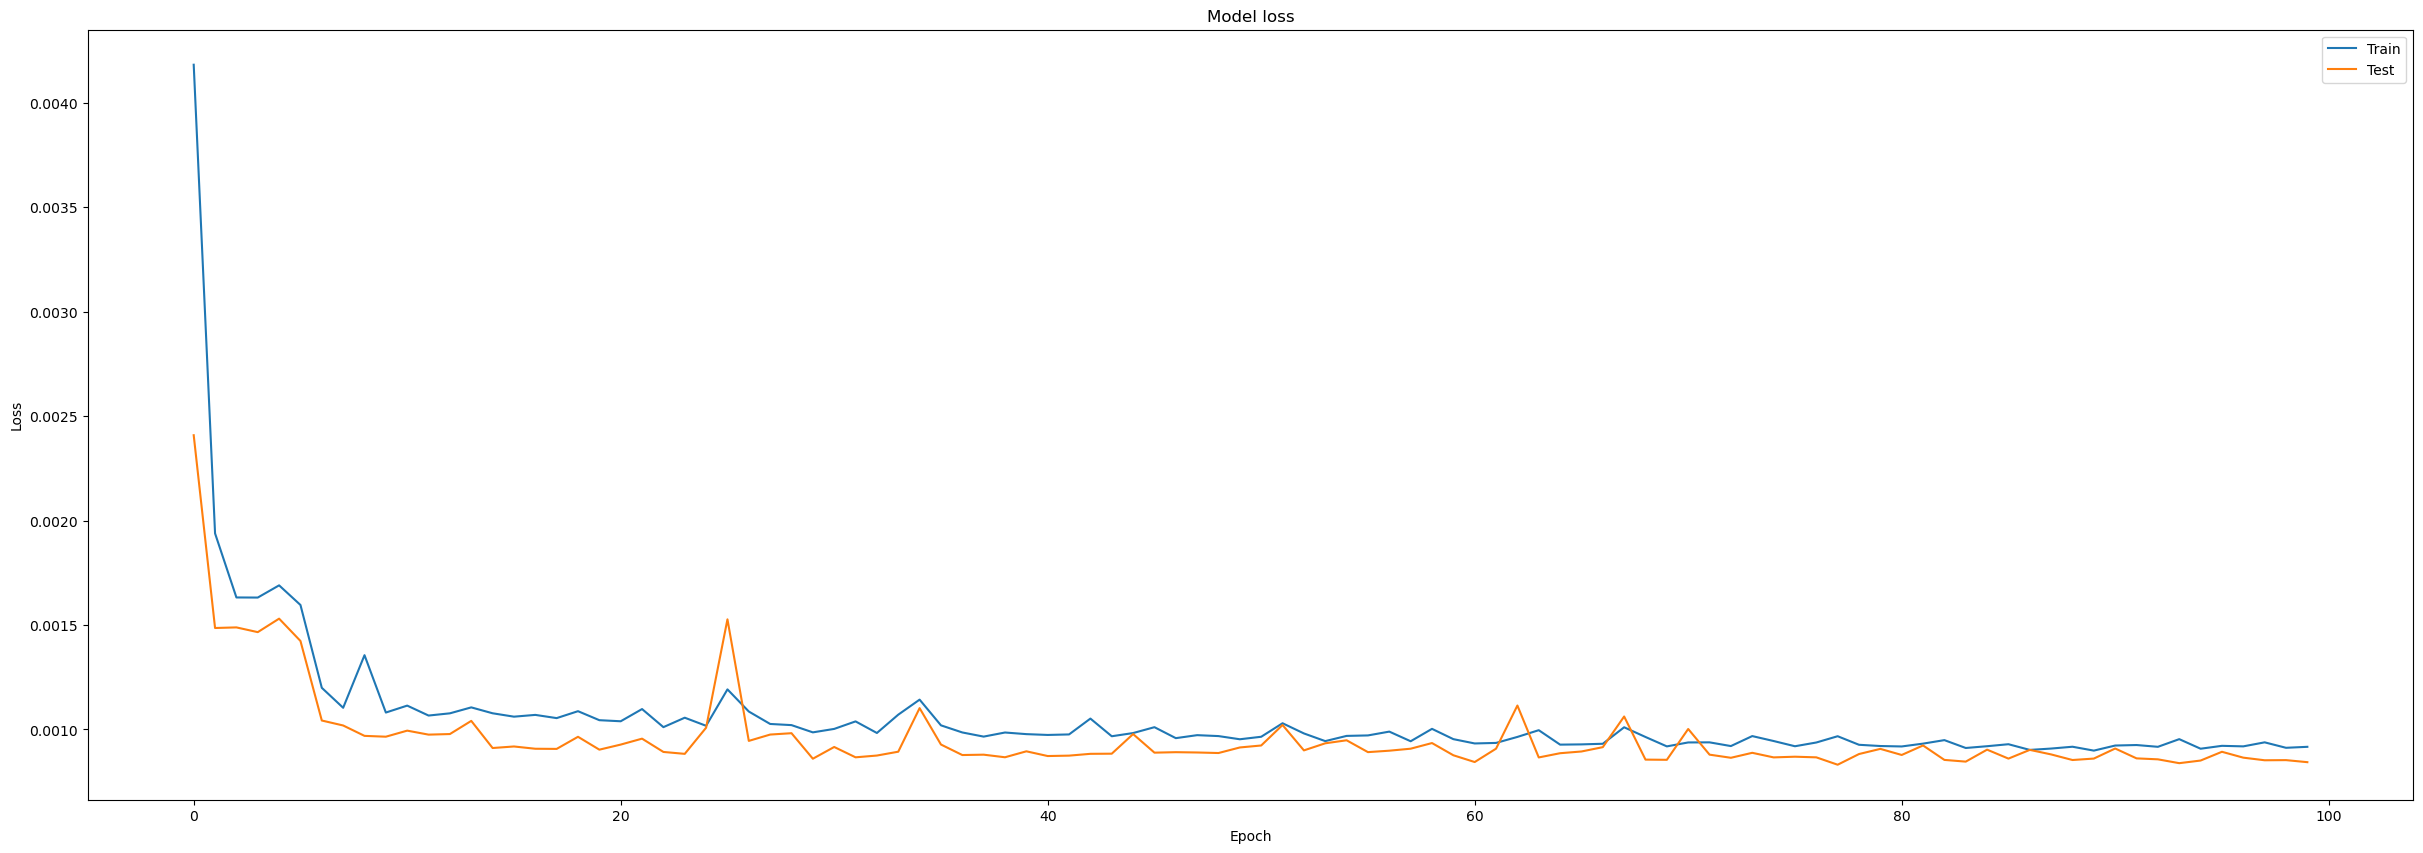

In [24]:
from tqdm.keras import TqdmCallback
model_file = "model/model.hdf5"
visualizer = Visualizer()
model = keras_model(sublist_size*3)
# model.summary()

print(reshaped_combine_data.shape)
train_data = ylists
tf.convert_to_tensor(train_data, dtype=tf.float32)

if os.path.exists(model_file):
    model.load_weights(model_file)

else:
    model.compile(
        optimizer="adam",
        loss= "mean_squared_error",
        metrics=['accuracy']
    )

    history = model.fit(x=reshaped_combine_data,
                        y=reshaped_combine_data,
                        epochs=100,
                        batch_size=10,
                        shuffle=True,
                        validation_split=0.1,
                        verbose=0,
                        callbacks=[TqdmCallback(verbose=1)])

    visualizer.loss_plot(
        history.history["loss"], history.history["val_loss"]
    )
    visualizer.save_figure("model/history.png")
    model.save_weights(model_file)

## Prediction

In [25]:
input_test = np.asarray(reshaped_combine_data[0])
input_test = np.reshape(input_test, (1,3072))
print(input_test.shape, input_test.ndim)

output_test = model.predict(input_test)
print(output_test.shape)
output_test

(1, 3072) 2
1/1 [==============================] - 0s 92ms/step
(1, 3072)


array([[0.40726566, 0.40723684, 0.40683407, ..., 0.33645993, 0.3364332 ,
        0.33604437]], dtype=float32)

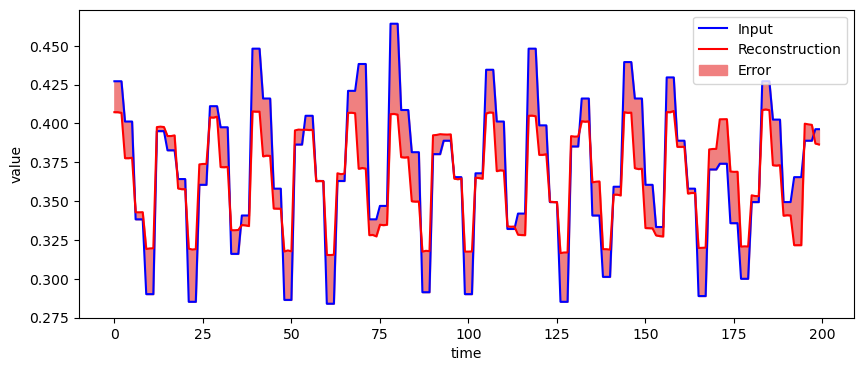

In [26]:
x_axis = 200
plt.figure(figsize=(10,4))
y1 = input_test.flatten()[:x_axis]
plt.plot(y1, 'b')
y2 = output_test.flatten()[:x_axis]
plt.plot(y2, 'r')
plt.xlabel('time')
plt.ylabel('value')
plt.fill_between(np.arange(x_axis),y1,y2,color='lightcoral' )
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

In [27]:
# Error test
error_input = np.random.rand(1, 3072)
error_output = model.predict(error_input)


1/1 [==============================] - 0s 14ms/step


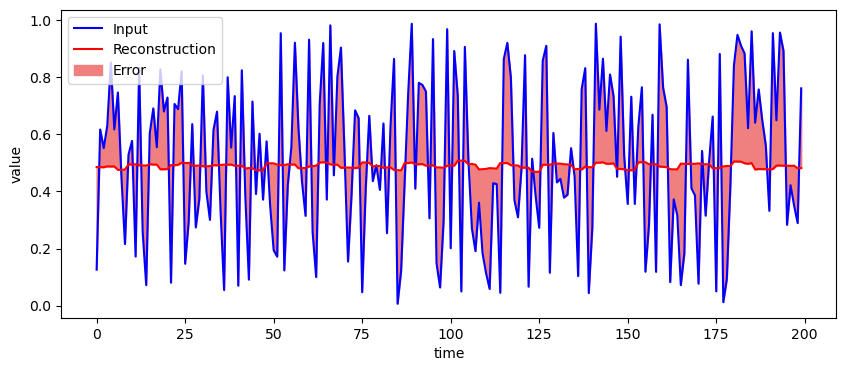

In [28]:
x_axis = 200
plt.figure(figsize=(10,4))
y1 = error_input.flatten()[:x_axis]
plt.plot(y1, 'b')
y2 = error_output.flatten()[:x_axis]
plt.plot(y2, 'r')
plt.xlabel('time')
plt.ylabel('value')
plt.fill_between(np.arange(x_axis),y1,y2,color='lightcoral' )
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

1/1 [==============================] - 0s 13ms/step


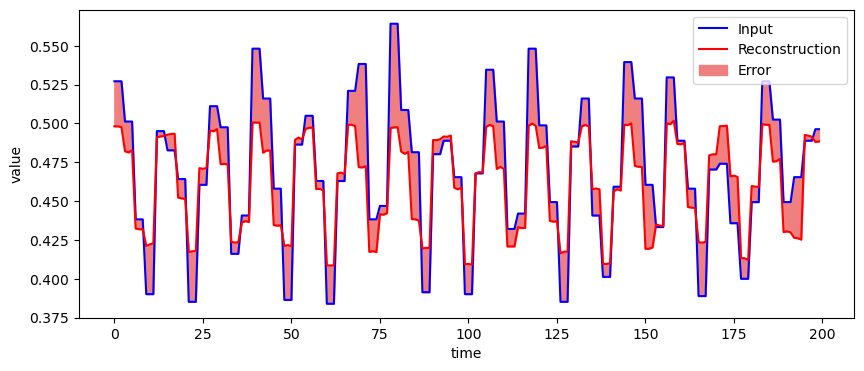

In [29]:
error_input1 = input_test + 0.1
error_output1 = model.predict(error_input1)
x_axis = 200
plt.figure(figsize=(10,4))
y1 = error_input1.flatten()[:x_axis]
plt.plot(y1, 'b')
y2 = error_output1.flatten()[:x_axis]
plt.plot(y2, 'r')
plt.xlabel('time')
plt.ylabel('value')
plt.fill_between(np.arange(x_axis),y1,y2,color='lightcoral' )
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

1/1 [==============================] - 0s 13ms/step


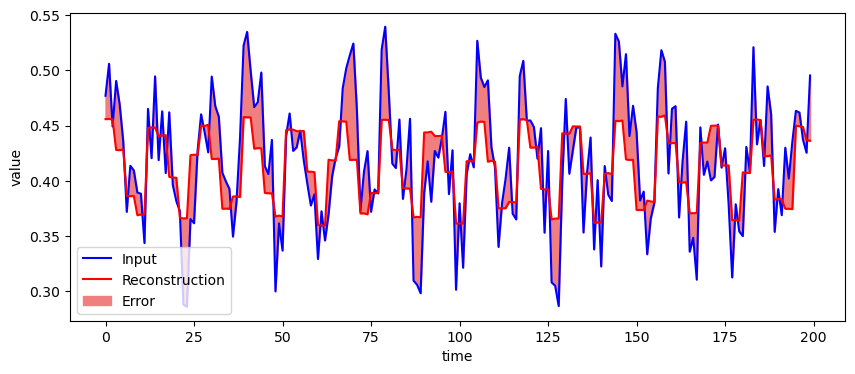

In [30]:
error_input2 = input_test + np.random.rand(1,3072) * 0.1
error_output2 = model.predict(error_input2)
x_axis = 200
plt.figure(figsize=(10,4))
y1 = error_input2.flatten()[:x_axis]
plt.plot(y1, 'b')
y2 = error_output2.flatten()[:x_axis]
plt.plot(y2, 'r')
plt.xlabel('time')
plt.ylabel('value')
plt.fill_between(np.arange(x_axis),y1,y2,color='lightcoral' )
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

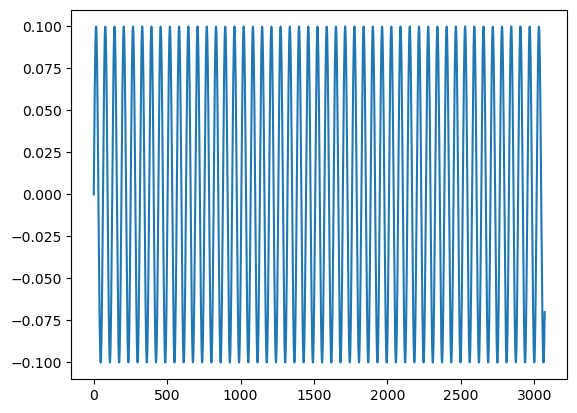

In [31]:
time = np.arange(0,3072,1)
sine_wave = np.sin(time*0.1)
sine_wave
plt.plot(time,0.1*sine_wave)

1/1 [==============================] - 0s 13ms/step


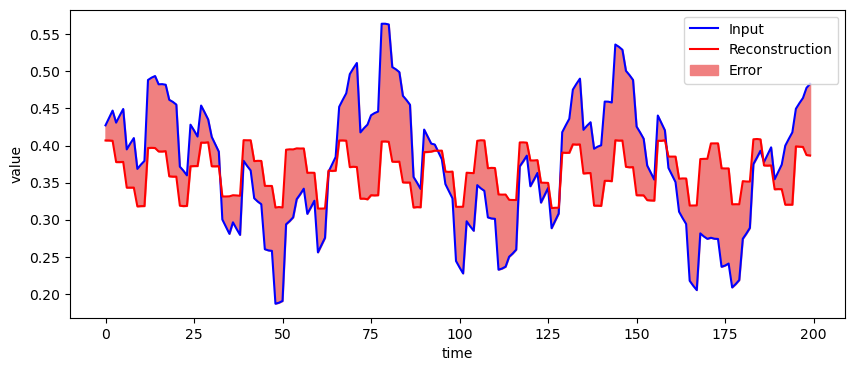

In [32]:
error_input3 = input_test + 0.1 * sine_wave
error_output3 = model.predict(error_input3)
x_axis = 200
plt.figure(figsize=(10,4))
y1 = error_input3.flatten()[:x_axis]
plt.plot(y1, 'b')
y2 = error_output3.flatten()[:x_axis]
plt.plot(y2, 'r')
plt.xlabel('time')
plt.ylabel('value')
plt.fill_between(np.arange(x_axis),y1,y2,color='lightcoral' )
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

In [33]:
reconstructions = model.predict(reshaped_combine_data,verbose=2)
train_loss = tf.keras.losses.mse(reshaped_combine_data,reconstructions)

141/141 - 0s - 178ms/epoch - 1ms/step


## Calculating the threshod

In [34]:
def predict(model, data, threshold):
    reconstruction = model(data)
    loss = tf.keras.mae(reconstruction, data)
    return tf.math.less(loss, threshold)

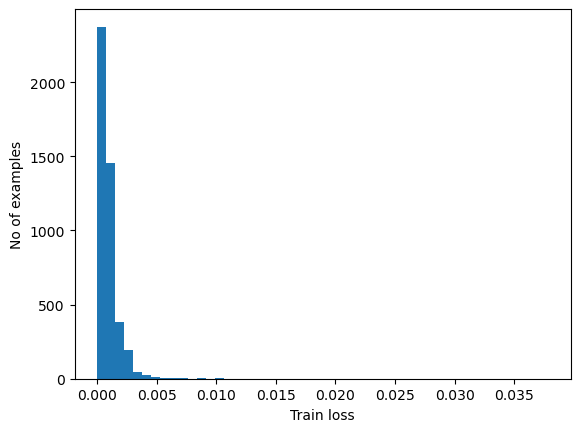

In [35]:
plt.hist(train_loss.numpy(),bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [36]:
train_loss

<tf.Tensor: shape=(4510,), dtype=float32, numpy=
array([0.00059577, 0.00102422, 0.00054914, ..., 0.00149019, 0.00109004,
       0.00101421], dtype=float32)>

In [37]:
threshod = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshod)

Threshold:  0.002059405
